<a href="https://colab.research.google.com/github/johnpaipa/semanticSegmentation/blob/main/U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
###PYTORCH CON U-NET 
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset, random_split
#
import PIL
from PIL import Image
#
!pip install jupyterthemes
from jupyterthemes import jtplot
jtplot.style()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 44.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 KB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 65.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 5.9 MB/s eta 0:00:00


In [ ]:
!git clone https://github.com/jhon-aparicio/semanticSegmentation.git

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
PATH = '/content/semanticSegmentation/dataset/persona/'
TRAIN_PATH = '/content/semanticSegmentation/dataset/persona/train2/'
TRAIN_MASKS_PATH = '/content/semanticSegmentation/dataset/persona/segmentadas/'
TEST_PATH = '/content/semanticSegmentation/dataset/persona/val2/'
TEST_MASK_PATH = '/content/semanticSegmentation/dataset/persona/valS/'

In [ ]:
class Person_Dataset(Dataset):
    def __init__(self, data, masks=None, img_transforms=None, mask_transforms=None):
        '''
        data - train data path
        masks - train masks path
        '''
        self.train_data = data
        self.train_masks = masks
        
        self.img_transforms = img_transforms
        self.mask_transforms = mask_transforms
        
        self.images = sorted(os.listdir(self.train_data))
        self.masks = sorted(os.listdir(self.train_masks))
        
    def __len__(self):
        if self.train_masks is not None:
            assert len(self.images)==len(self.masks), 'not the same number of images and masks'
        return len(self.images)
        
    def __getitem__(self, idx):
        image_name = os.path.join(self.train_data, self.images[idx])
        img = Image.open(image_name)
        trans = T.ToTensor()
        if self.img_transforms is not None:
            img = self.img_transforms(img)
        else:
            img =trans(img)
            img = torch.narrow(img, 1, 0, 3)
        
        if self.train_masks is not None:
            mask_name = os.path.join(self.train_masks, self.masks[idx])
            mask = Image.open(mask_name)
            if self.mask_transforms is not None:
                mask = self.mask_transforms(mask)
            else:
                mask = trans(mask)
            
            mask_max = mask.max().item()
            mask /= mask_max
        else:
            return img 

        return img, mask 

In [ ]:
transform_data = T.Compose([
                T.Resize([224, 224]),
                T.ToTensor()] )

In [ ]:
full_dataset = Person_Dataset(TRAIN_PATH,
                           TRAIN_MASKS_PATH,
                           img_transforms=transform_data,
                           mask_transforms=transform_data)

In [ ]:
BATCH_SIZE = 4
TRAIN_SIZE = int(len(full_dataset)*0.8)
VAL_SIZE = len(full_dataset) - TRAIN_SIZE

print(TRAIN_SIZE, VAL_SIZE)

41 11


In [ ]:
train_dataset, val_dataset = random_split(full_dataset, [TRAIN_SIZE, VAL_SIZE])
print(len(train_dataset), len(val_dataset))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
for batch_idx, (inputs, targets) in enumerate(train_loader):
    print(f'Batch {batch_idx}: inputs={inputs.shape}, targets={targets.shape}')

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

41 11
Batch 0: inputs=torch.Size([4, 4, 224, 224]), targets=torch.Size([4, 1, 224, 224])
Batch 1: inputs=torch.Size([4, 4, 224, 224]), targets=torch.Size([4, 1, 224, 224])
Batch 2: inputs=torch.Size([4, 4, 224, 224]), targets=torch.Size([4, 1, 224, 224])
Batch 3: inputs=torch.Size([4, 4, 224, 224]), targets=torch.Size([4, 1, 224, 224])
Batch 4: inputs=torch.Size([4, 4, 224, 224]), targets=torch.Size([4, 1, 224, 224])
Batch 5: inputs=torch.Size([4, 4, 224, 224]), targets=torch.Size([4, 1, 224, 224])
Batch 6: inputs=torch.Size([4, 4, 224, 224]), targets=torch.Size([4, 1, 224, 224])
Batch 7: inputs=torch.Size([4, 4, 224, 224]), targets=torch.Size([4, 1, 224, 224])
Batch 8: inputs=torch.Size([4, 4, 224, 224]), targets=torch.Size([4, 1, 224, 224])
Batch 9: inputs=torch.Size([4, 4, 224, 224]), targets=torch.Size([4, 1, 224, 224])
Batch 10: inputs=torch.Size([1, 4, 224, 224]), targets=torch.Size([1, 1, 224, 224])


In [ ]:
imgs, masks = next(iter(train_loader))
print(imgs.shape, masks.shape)
#imgs = torch.narrow(imgs, 1, 0, 3)
#print(imgs.shape)
for i, (x, y) in enumerate(train_loader):
    x = torch.narrow(x, 1, 0, 3)
    print(i, x.shape, y.shape)
    if i==9: break

torch.Size([4, 4, 224, 224]) torch.Size([4, 1, 224, 224])
0 torch.Size([4, 3, 224, 224]) torch.Size([4, 1, 224, 224])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 1, 224, 224])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 1, 224, 224])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 1, 224, 224])
4 torch.Size([4, 3, 224, 224]) torch.Size([4, 1, 224, 224])
5 torch.Size([4, 3, 224, 224]) torch.Size([4, 1, 224, 224])
6 torch.Size([4, 3, 224, 224]) torch.Size([4, 1, 224, 224])
7 torch.Size([4, 3, 224, 224]) torch.Size([4, 1, 224, 224])
8 torch.Size([4, 3, 224, 224]) torch.Size([4, 1, 224, 224])
9 torch.Size([4, 3, 224, 224]) torch.Size([4, 1, 224, 224])


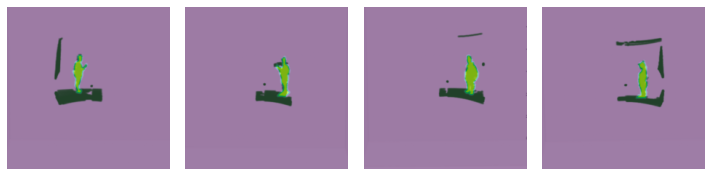

In [ ]:
imgs, masks = next(iter(train_loader))
def plot_mini_batch(imgs, masks):
    plt.figure(figsize=(20,10))
    for i in range(BATCH_SIZE):
        plt.subplot(4, 8, i+1)
        img=imgs[i,...].permute(1,2,0).numpy()
        mask = masks[i, ...].permute(1,2,0).numpy()
        plt.imshow(img)
        plt.imshow(mask, alpha=0.5)
        
        plt.axis('Off')
    plt.tight_layout()
    plt.show()

plot_mini_batch(imgs, masks)

In [ ]:
def accuracy(model, loader):
    correct = 0
    intersection = 0
    denom = 0
    union = 0
    total = 0
    cost = 0.
    model = model.to(device=device)
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype = torch.float32)
            x = torch.narrow(x, 1, 0, 3)
            y = y.to(device=device, dtype = torch.long).squeeze(1)
            scores = model(x)
            cost += (F.cross_entropy(scores, y)).item()
            # standard accuracy not optimal
            preds = torch.argmax(scores, dim=1)
            correct += (preds == y).sum()
            total += torch.numel(preds)
            #dice coefficient
            intersection += (preds*y).sum()
            denom += (preds + y).sum()
            dice = 2*intersection/(denom + 1e-8)
            #intersection over union
            union += (preds + y - preds*y).sum()
            iou = (intersection)/(union + 1e-8)
            
        return cost/len(loader), float(correct)/total, dice, iou

In [ ]:
def find_lr(model, optimiser, start_val = 1e-6, end_val = 1, beta = 0.99, loader = train_loader):
    n = len(loader) - 1
    factor = (end_val / start_val)**(1/n)
    lr = start_val
    optimiser.param_groups[0]['lr'] = lr #this allows you to update the learning rate
    avg_loss, loss, acc = 0., 0., 0.
    lowest_loss = 0.
    batch_num = 0
    losses = []
    log_lrs = []
    accuracies = []
    model = model.to(device=device)
    for i, (x, y) in enumerate(loader, start=1):
        x = x.to(device = device, dtype = torch.float32)
        x = torch.narrow(x, 1, 0, 3)
        y = y.to(device = device, dtype = torch.long).squeeze(1)
        optimiser.zero_grad()
        scores = model(x)
        cost = F.cross_entropy(input=scores, target=y)
        loss = beta*loss + (1-beta)*cost.item()
        avg_loss = loss/(1 - beta**i)
        
        preds = torch.argmax(scores, dim=1)
        acc_ = (preds == y).sum()/torch.numel(scores)
        if i > 1 and avg_loss > 4 * lowest_loss:
            print(f'from here{i, cost.item()}')
            return log_lrs, losses, accuracies
        if avg_loss < lowest_loss or i == 1:
            lowest_loss = avg_loss

        accuracies.append(acc_.item())
        losses.append(avg_loss)
        log_lrs.append(lr)
        #step
        cost.backward()
        optimiser.step()
        #update lr
        print(f'cost:{cost.item():.4f}, lr: {lr:.4f}, acc: {acc_.item():.4f}')
        lr *= factor
        optimiser.param_groups[0]['lr'] = lr
        
    return log_lrs, losses, accuracies

In [ ]:
def evaluate(model, loader):
    model.eval()
    model.to(device=device)
    with torch.no_grad():
        true_positives = 0
        false_positives = 0
        false_negatives = 0
        total = 0
        cost = 0
        for x, y in loader:
            x = x.to(device=device, dtype=torch.float32)
            x = torch.narrow(x, 1, 0, 3)
            y = y.to(device=device, dtype=torch.long).squeeze(1)
            scores = model(x)
            cost += (F.cross_entropy(scores, y)).item()
            preds = torch.argmax(scores, dim=1)
            true_positives += ((preds == 1) & (y == 1)).sum().item()
            false_positives += ((preds == 1) & (y == 0)).sum().item()
            false_negatives += ((preds == 0) & (y == 1)).sum().item()
            total += torch.numel(preds)
        accuracy = true_positives / total
        recall = true_positives / (true_positives + false_negatives)
        precision = true_positives / (true_positives + false_positives)
        if (precision + recall) ==0:
            f1_score = 0
        else:
            f1_score = 2 * (precision * recall) / (precision + recall)
        true_negatives = total - true_positives - false_positives - false_negatives
        confusion_matrix = [[true_positives, false_positives], [false_negatives, true_negatives]]
        print("Confusion Matrix:")
        print(confusion_matrix)
        return cost / len(loader), accuracy, recall, precision, f1_score, confusion_matrix

In [ ]:
import torch
from sklearn.metrics import confusion_matrix
def lift(model, loader):
    thresholds = torch.arange(0, 1.01, 0.01)
    tprs = []
    fprs = []
    for threshold in thresholds:
        true_positives = 0
        false_positives = 0
        false_negatives = 0
        true_negatives = 0
        total = 0
        for x, y in loader:
            x = x.to(device=device, dtype=torch.float32)
            x = torch.narrow(x, 1, 0, 3)
            y = y.to(device=device, dtype=torch.long).squeeze(1)
            scores = model(x)
            preds = torch.where(scores[:, 1] > threshold, torch.tensor(1).to(device=device), torch.tensor(0).to(device=device))
            true_positives += ((preds == 1) & (y == 1)).sum().item()
            false_positives += ((preds == 1) & (y == 0)).sum().item()
            false_negatives += ((preds == 0) & (y == 1)).sum().item()
            true_negatives += ((preds == 0) & (y == 0)).sum().item()
            total += torch.numel(preds)
        tpr = true_positives / (true_positives + false_negatives)
        fpr = false_positives / (false_positives + true_negatives)
        tprs.append(tpr)
        fprs.append(fpr)
    return fprs, tprs

In [ ]:
def train(model, optimiser, scheduler = None, epochs = 5000, store_every = 25):
    model = model.to(device=device)
    for epoch in range(epochs):
        train_correct_num = 0
        train_total = 0
        train_cost_acum = 0.
        for mb, (x, y) in enumerate(train_loader, start=1):
            model.train()
            x = x.to(device=device, dtype=torch.float32)
            x = torch.narrow(x, 1, 0, 3)
            y = y.to(device=device, dtype=torch.long).squeeze(1)
            scores = model(x)
            cost = F.cross_entropy(input=scores, target=y)
            optimiser.zero_grad()
            cost.backward()
            optimiser.step()
            
            if scheduler: 
                scheduler.step()
                
            train_predictions = torch.argmax(scores, dim=1)
            train_correct_num += (train_predictions == y).sum()
            train_total += torch.numel(train_predictions)
            train_cost_acum += cost.item()
            if mb%store_every == 0:
                val_cost, val_acc, dice, iou = accuracy(model, val_loader)
                train_acc = float(train_correct_num)/train_total
                train_cost_every = float(train_cost_acum)/mb
                loss, accuracy2, recall, precision, f1_score, confusion_matrix = evaluate(model, val_loader)
                print(f'epoch: {epoch}, mb: {mb}, train cost: {train_cost_every:.4f}, val cost: {val_cost:.4f},'
                      f'train acc: {train_acc:.4f}, val acc: {val_acc:.4f},'
                      f'dice: {dice}, iou: {iou}')
            else:
                val_cost, val_acc, dice, iou = accuracy(model, val_loader)
                train_acc = float(train_correct_num)/train_total
                train_cost_every = float(train_cost_acum)/mb
                print(f'epoch: {epoch}, mb: {mb}, train cost: {train_cost_every:.4f}, val cost: {val_cost:.4f},'
                      f'train acc: {train_acc:.4f}, val acc: {val_acc:.4f},'
                      f'dice: {dice}, iou: {iou}')              
   

In [ ]:
class Conv_3_k(nn.Module):
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.conv1 = nn.Conv2d(channels_in, channels_out, kernel_size=3, stride=1, padding=1)
    def forward(self, x):
        return self.conv1(x)

In [ ]:
class Double_Conv(nn.Module):
    '''
    Double convolution block for U-Net
    '''
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.double_conv = nn.Sequential(
                           Conv_3_k(channels_in, channels_out),
                           nn.BatchNorm2d(channels_out),
                           nn.ReLU(),
            
                           Conv_3_k(channels_out, channels_out),
                           nn.BatchNorm2d(channels_out),
                           nn.ReLU(),
                            )
    def forward(self, x):
        return self.double_conv(x)
    
class Down_Conv(nn.Module):
    '''
    Down convolution part
    '''
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.encoder = nn.Sequential(
                        nn.MaxPool2d(2,2),
                        Double_Conv(channels_in, channels_out)
                        )
    def forward(self, x):
        return self.encoder(x)
    
class Up_Conv(nn.Module):
    '''
    Up convolution part
    '''
    def __init__(self,channels_in, channels_out):
        super().__init__()
        self.upsample_layer = nn.Sequential(
                        nn.Upsample(scale_factor=2, mode='bicubic'),
                        nn.Conv2d(channels_in, channels_in//2, kernel_size=1, stride=1)
                        )
        self.decoder = Double_Conv(channels_in, channels_out)
    
    def forward(self, x1, x2):
        '''
        x1 - upsampled volume
        x2 - volume from down sample to concatenate
        '''
        x1 = self.upsample_layer(x1)
        x = torch.cat([x2, x1],dim=1)
        return self.decoder(x)
    
class UNET(nn.Module):
    '''
    UNET model
    '''
    def __init__(self, channels_in, channels, num_classes):
        super().__init__()
        self.first_conv = Double_Conv(channels_in, channels) #64, 224, 224
        self.down_conv1 = Down_Conv(channels, 2*channels) # 128, 112, 112
        self.down_conv2 = Down_Conv(2*channels, 4*channels) # 256, 56, 56
        self.down_conv3 = Down_Conv(4*channels, 8*channels) # 512, 28, 28
        
        self.middle_conv = Down_Conv(8*channels, 16*channels) # 1024, 14, 14 
        
        self.up_conv1 = Up_Conv(16*channels, 8*channels)
        self.up_conv2 = Up_Conv(8*channels, 4*channels)
        self.up_conv3 = Up_Conv(4*channels, 2*channels)
        self.up_conv4 = Up_Conv(2*channels, channels)
        
        self.last_conv = nn.Conv2d(channels, num_classes, kernel_size=1, stride=1)
        
    def forward(self, x):
        x1 = self.first_conv(x)
        x2 = self.down_conv1(x1)
        x3 = self.down_conv2(x2)
        x4 = self.down_conv3(x3)
        
        x5 = self.middle_conv(x4)
        
        u1 = self.up_conv1(x5, x4)
        u2 = self.up_conv2(u1, x3)
        u3 = self.up_conv3(u2, x2)
        u4 = self.up_conv4(u3, x1)
        
        return self.last_conv(u4)

In [ ]:
torch.manual_seed(42)
model = UNET(3, 4, 2)
optimiser_unet = torch.optim.SGD(model.parameters(),
                                 lr=0.01, momentum=0.95,
                                 weight_decay=1e-4)

lg_lr, losses, accuracies = find_lr(model, optimiser_unet, start_val=1e-6, end_val=10)

cost:0.9044, lr: 0.0000, acc: 0.0609
cost:0.8980, lr: 0.0000, acc: 0.0661
cost:0.9003, lr: 0.0000, acc: 0.0659
cost:0.8988, lr: 0.0001, acc: 0.0620
cost:0.8969, lr: 0.0006, acc: 0.0660
cost:0.8780, lr: 0.0032, acc: 0.0930
cost:0.8400, lr: 0.0158, acc: 0.1187
cost:0.7175, lr: 0.0794, acc: 0.1891
cost:0.3150, lr: 0.3981, acc: 0.4970
cost:0.0291, lr: 1.9953, acc: 0.4984
cost:0.3405, lr: 10.0000, acc: 0.4976


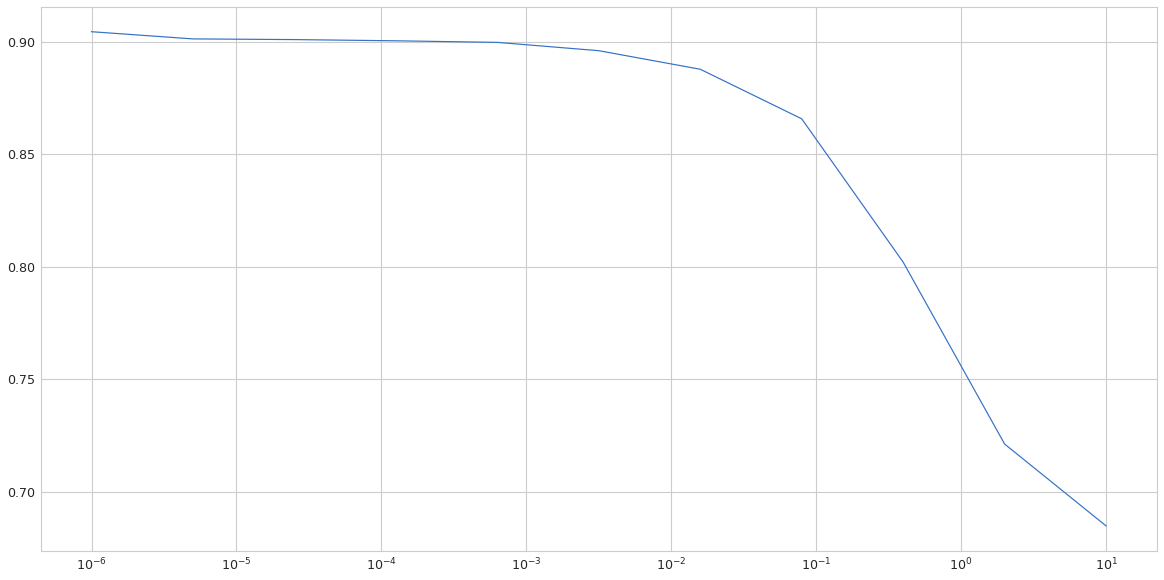

In [ ]:
# plot loss vs learning rate
f1, ax1 = plt.subplots(figsize=(20,10))
ax1.plot(lg_lr, losses)
ax1.set_xscale('log')
plt.show()

In [ ]:
torch.manual_seed(42)
model = UNET(3, 4, 2)
epochs = 750
optimiser_unet = torch.optim.SGD(model.parameters(),
                                 lr=0.01, momentum=0.95,
                                 weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimiser_unet, 
                                                max_lr = 1e-1,
                                                steps_per_epoch=len(train_loader),
                                                epochs=epochs, pct_start=0.43, div_factor=10, final_div_factor=1000,
                                                three_phase=True)

In [ ]:
train(model, optimiser_unet, scheduler, epochs)
loss, accuracy2, recall, precision, f1_score, confusion_matrix = evaluate(model, val_loader)
print("Loss: {:.4f}".format(loss))
print("Accuracy: {:.4f}".format(accuracy2))
print("Recall: {:.4f}".format(recall))
print("Precision: {:.4f}".format(precision))
print("F1 Score: {:.4f}".format(f1_score))

Streaming output truncated to the last 5000 lines.
epoch: 151, mb: 1, train cost: 0.0009, val cost: 0.0067,train acc: 0.9997, val acc: 0.9982,dice: 0.7822845578193665, iou: 0.6424198746681213
epoch: 151, mb: 2, train cost: 0.0011, val cost: 0.0066,train acc: 0.9996, val acc: 0.9983,dice: 0.7932306528091431, iou: 0.6573175191879272
epoch: 151, mb: 3, train cost: 0.0011, val cost: 0.0065,train acc: 0.9996, val acc: 0.9982,dice: 0.7906099557876587, iou: 0.6537261605262756
epoch: 151, mb: 4, train cost: 0.0011, val cost: 0.0065,train acc: 0.9996, val acc: 0.9981,dice: 0.7833607792854309, iou: 0.6438727378845215
epoch: 151, mb: 5, train cost: 0.0011, val cost: 0.0062,train acc: 0.9996, val acc: 0.9982,dice: 0.7945435643196106, iou: 0.6591225862503052
epoch: 151, mb: 6, train cost: 0.0011, val cost: 0.0061,train acc: 0.9996, val acc: 0.9983,dice: 0.8003420233726501, iou: 0.667141854763031
epoch: 151, mb: 7, train cost: 0.0010, val cost: 0.0060,train acc: 0.9996, val acc: 0.9983,dice: 0.80026

In [ ]:
torch.save(model.state_dict(), 'model_trained1.pth')

In [ ]:
print("Confusion Matrix:")
print(confusion_matrix)
tp, fp = confusion_matrix[0]
fn, tn = confusion_matrix[1]

# Crear una lista con los nombres de las clases
class_names = ["True Positive", "False Positive", "False Negative", "True Negative"]

# Crear una figura y un eje para el gráfico de barras
fig, ax = plt.subplots()

# Crear el gráfico de barras
ax.bar(class_names, [tp, fp, fn, tn], color=["green", "red", "red", "green"])

# Configurar las etiquetas de los ejes y el título del gráfico
ax.set_xlabel("Class")
ax.set_ylabel("Number of samples")
ax.set_title("Confusion Matrix")

# Mostrar el gráfico
plt.show()

In [ ]:
####CURVAS ROC
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

cm = confusion_matrix
print(cm)
cm = np.array(cm)

y_true = np.concatenate([np.zeros(cm[0, 0] + cm[0, 1]), np.ones(cm[1, 0] + cm[1, 1])])
y_scores = np.concatenate([np.zeros(cm[0, 0]), np.ones(cm[1, 0]), np.zeros(cm[0, 1]), np.ones(cm[1, 1])])

# Calcular la tasa de verdaderos positivos (TPR) y la tasa de falsos positivos (FPR) para diferentes umbrales de clasificación
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# Calcular el área bajo la curva ROC (AUC)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

In [ ]:
fprs, tprs = lift(model, val_loader)
import matplotlib.pyplot as plt
plt.plot(fprs, tprs)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [ ]:
imgs_val, masks_val = next(iter(val_loader))
imgs_val = imgs_val.to(device, dtype=torch.float32)
imgs_val = torch.narrow(imgs_val, 1, 0, 3)
model = model.to(device)
with torch.no_grad():
    scores = model(imgs_val)
    preds = torch.argmax(scores, dim=1).float()

imgs_val = imgs_val.cpu()
preds = preds.cpu()
print(preds.shape)
plot_mini_batch(imgs_val, preds.unsqueeze(1))

In [ ]:
###PRUEBA // TESTEO
test_set = Person_Dataset(TEST_PATH, img_transforms=transform_data)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
imgs_test = next(iter(test_loader))
imgs_test = imgs_test.to(device, dtype=torch.float32)
imgs_test = torch.narrow(imgs_test, 1, 0, 3)
model = model.to(device)
with torch.no_grad():
    scores = model(imgs_test)
    preds = torch.argmax(scores, dim=1).float()

imgs_test = imgs_test.cpu()
preds = preds.cpu()
print(preds.shape)
plot_mini_batch(imgs_test, preds.unsqueeze(1))

In [ ]:
###PARA IMPRIMIR TODO EL DATASET
model = model.to(device)
with torch.no_grad():
    for batch in test_loader:
        imgs_test = batch.to(device, dtype=torch.float32)
        print(imgs_test.shape)
        imgs_test = torch.narrow(imgs_test, 1, 0, 3)
        
        scores = model(imgs_test)
        preds = torch.argmax(scores, dim=1).float()

        imgs_test = imgs_test.cpu()
        preds = preds.cpu()
        plot_mini_batch(imgs_test, preds.unsqueeze(1))